In [2]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from data_loader import DataLoader
import random
import matplotlib.pyplot as plt
random.seed(1)
np.random.seed(1)

In [3]:
def split_train_test(images, masks, validation_split=0.8):
    split_index = int(images.shape[0] * 0.8)
    return images[0:split_index], masks[0:split_index], images[split_index:], masks[split_index:]

def normalize(images, masks):
    images = images / 255
    masks = (masks > 0).astype(float)
    return images, masks

In [4]:
raw_images, raw_masks = DataLoader().get_dataset()
norm_images, norm_masks = normalize(raw_images, raw_masks)

train_img, train_msk, test_img, test_msk = split_train_test(norm_images, norm_masks)

train_img.shape

(14, 512, 512, 1)

In [5]:
valid_data = np.array( (test_img, test_msk) )
valid_data.shape

(2, 4, 512, 512, 1)

## HYPERPARAMETERS

In [6]:
image_size = 512
train_path = 'src/dataset_preview/train/'
EPOCHS = 5
BATCH_SIZE = 2



## Visualization 

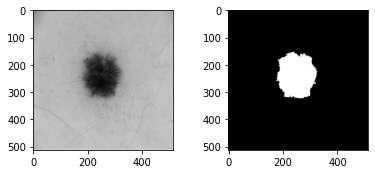

In [7]:
r = 1 #random.randint(0, len(train_img.shape) - 1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.imshow(train_img[r], cmap='gray')
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(train_msk[r], cmap='gray')


## Convolutional Blocks

In [8]:
def down_block(x, filters, kernel_size=(3,3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)

    p = keras.layers.MaxPool2D((2,2), (2,2))(c)
    return c, p 

def up_block(x, skip, filters, kernel_size=(3,3), padding="same", strides=1):
    up_sampling = keras.layers.UpSampling2D((2,2))(x)
    concat = keras.layers.Concatenate()([up_sampling, skip])

    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)

    return c

def bottleneck(x, filters, kernel_size=(3,3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)

    return c

## UNet Model

In [9]:
def UNet():
    feature_maps = [64,128,256, 512, 1024]
    inputs = keras.layers.Input( (image_size, image_size, 1) )

    pool_0 = inputs
    conv_1, pool_1 = down_block(pool_0, feature_maps[0]) #512 -> 256
    conv_2, pool_2 = down_block(pool_1, feature_maps[1]) #256 -> 128 
    conv_3, pool_3 = down_block(pool_2, feature_maps[2]) #128 -> 64
    conv_4, pool_4 = down_block(pool_3, feature_maps[3]) #64 -> 32

    bn = bottleneck(pool_4, feature_maps[4])

    ups_1 = up_block(bn, conv_4, feature_maps[3]) #32 -> 64
    ups_2 = up_block(ups_1, conv_3, feature_maps[2]) #64 -> 128
    ups_3 = up_block(ups_2, conv_2, feature_maps[1]) #128 -> 256
    ups_4 = up_block(ups_3, conv_1, feature_maps[0]) #256 -> 512

    outputs = keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(ups_4)

    model = keras.models.Model(inputs, outputs)
    return model

In [25]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis=-1)
    sum_ = keras.backend.sum(keras.backend.square(y_true), axis = -1) + keras.backend.sum(keras.backend.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)


In [26]:
model = UNet()

model.compile(optimizer='adam', loss=jaccard_distance, metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [11]:
v_data = (test_img, test_msk)
v_data

(array([[[[0.58039216],
          [0.38039216],
          [0.38431373],
          ...,
          [0.38431373],
          [0.38039216],
          [0.58431373]],
 
         [[0.30588235],
          [0.29803922],
          [0.36470588],
          ...,
          [0.37254902],
          [0.29411765],
          [0.30588235]],
 
         [[0.33333333],
          [0.54509804],
          [0.63529412],
          ...,
          [0.65490196],
          [0.54509804],
          [0.33333333]],
 
         ...,
 
         [[0.3372549 ],
          [0.55686275],
          [0.65098039],
          ...,
          [0.65098039],
          [0.54117647],
          [0.33333333]],
 
         [[0.29803922],
          [0.30980392],
          [0.36862745],
          ...,
          [0.37647059],
          [0.30196078],
          [0.29803922]],
 
         [[0.58039216],
          [0.38823529],
          [0.38823529],
          ...,
          [0.39215686],
          [0.38823529],
          [0.58039216]]],
 
 
        [

## Training the model

In [27]:
train_steps = len(train_img)
test_steps = len(test_img)



model.fit(x=train_img, y=train_msk, batch_size=BATCH_SIZE , epochs=2, validation_data=v_data)

Epoch 1/2
7/7 [==============================] - 119s 17s/step - loss: 0.0020 - acc: 0.7069 - val_loss: 0.0023 - val_acc: 0.7584
Epoch 2/2
7/7 [==============================] - 111s 16s/step - loss: 0.0019 - acc: 0.7690 - val_loss: 0.0015 - val_acc: 0.7584


In [41]:
model.save_weights('UNetW1.h5')

result = model.predict(test_img)



<class 'numpy.ndarray'> 0.2703285217285156


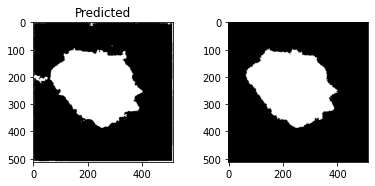

In [61]:
r = 1

res = (result > 0.25).astype(float)
print(type(result[r]), np.mean(res[r]))

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.set_title('Ground Truth')
ax.imshow(test_msk[r], cmap='gray')


ax1 = fig.add_subplot(1,2,2)
ax1.set_title('Ground Truth')
ax1.imshow(res[r], cmap='gray')


0.13243484497070312